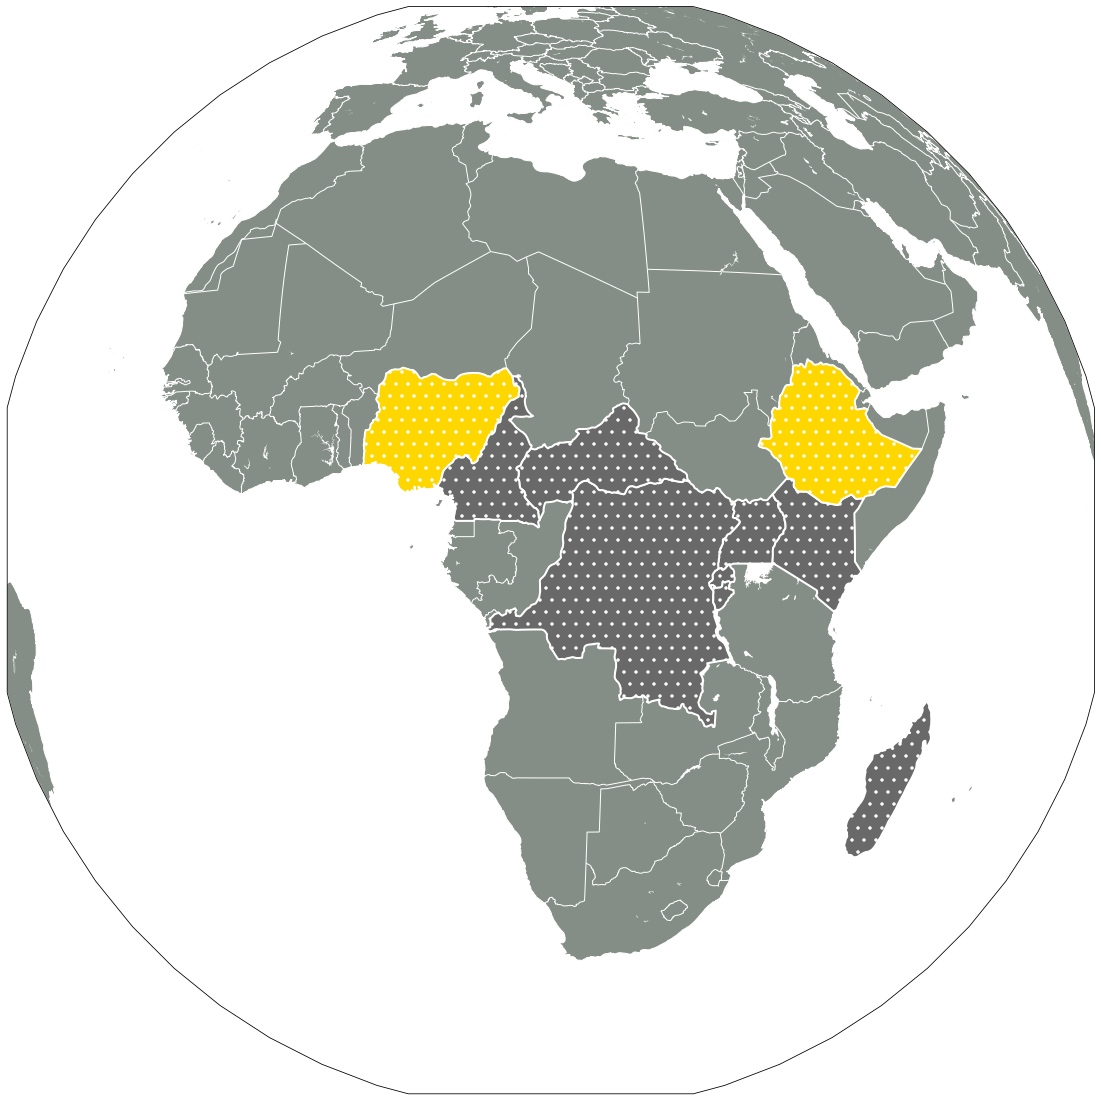

In [12]:
import matplotlib as mpl
from matplotlib import pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader

typeface = 'Helvetica Neue'
mpl.rcParams['font.weight'] = 300
mpl.rcParams['axes.labelweight'] = 300
mpl.rcParams['font.family'] = typeface
mpl.rcParams['font.size'] = 22
mpl.rcParams['pdf.fonttype'] = 42

class RP(ccrs.NearsidePerspective):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self._threshold = 1e3

    @property
    def threshold(self):
        return self._threshold

    @threshold.setter
    def threshold(self, value):
        self._threshold = value

fig, ax = plt.subplots(figsize=(20, 20), facecolor='w', subplot_kw={'projection': RP(central_longitude=17, central_latitude=0, satellite_height=14000000)})

scale = '10m'
water = 'w'
land = '#848E86'

ax.add_feature(cartopy.feature.LAKES.with_scale(scale), facecolor=water)
ax.add_feature(cartopy.feature.OCEAN.with_scale(scale), facecolor=water, edgecolor=water)
ax.add_feature(cartopy.feature.LAND.with_scale(scale), facecolor=land, edgecolor='w', zorder=1)
ax.add_feature(cartopy.feature.BORDERS.with_scale(scale), edgecolor='w', lw=1, zorder=2)

shpfilename = shpreader.natural_earth(resolution='50m', category='cultural', name='admin_0_countries')
reader = shpreader.Reader(shpfilename)
countries = reader.records()

focal_countries = ['CAR', 'Nigeria', 'Cameroon', 'Democratic Republic of the Congo', 'Republic of Congo', 'Uganda', 'Burundi', 'Madagascar', 'Kenya', 'Rwanda', "Ethiopia"]
reporting = ['']
#reporting = ['CAR', 'Nigeria', 'Cameroon', 'Democratic Republic of the Congo']

# Define colors for the specific countries
color_dict = {
    'Ethiopia': 'gold',
    
    'Nigeria': 'gold',
    
}

for country in countries:
    name = country.attributes['ADMIN']
    if name == 'Central African Republic':
        name = 'CAR'
    
    if name in focal_countries:
        fc = color_dict.get(name, 'dimgrey')  # Default to 'dimgrey' if not found in color_dict
        hatch = '.'
        
        if name in reporting:
            hatch = '//'
        
        ax.add_geometries([country.geometry], ccrs.PlateCarree(),
                          facecolor=fc,
                          edgecolor='w', hatch=hatch, linewidth=2, zorder=1000)

# Adjust the limits to focus on the African continent
ax.set_xlim(-4456742.500225266, 4456742.500225266)
ax.set_ylim(-4456742.500225266, 4456742.500225266)

plt.savefig('MPOX_workshop.png')
plt.show()


In [10]:

import os

# Update to assume the JSON files are in the current working directory
current_directory = "/Volumes/aine_store/SENZOR_project/SPlited_SENSOR_porject/IDseq/Test_blast_SENZOR/Contig_quality"
files = [
    "AIAMACAT001_S69_657769_contig_stats.json",
    "AIAMADOG001_S40_657732_contig_stats.json",
    "AIAMAGOAT003_S50_657720_contig_stats.json",
]

# Initialize an empty list to collect the data
merged_data = []

# Process each JSON file
for file in files:
    file_path = os.path.join(current_directory, file)
    with open(file_path, 'r') as f:
        data = json.load(f)
    # Convert JSON key-value pairs into rows, excluding the '*' key
    rows = [[key, value] for key, value in data.items() if key != '*']
    merged_data.extend(rows)

# Convert the list of rows to a DataFrame
merged_df = pd.DataFrame(merged_data, columns=['Contig', 'Count'])

# Save the merged data as a TXT file
output_path = os.path.join(current_directory, "bowtie_csp_counts_1000.txt")
merged_df.to_csv(output_path, sep="\t", index=False, header=False)

output_path


'/Volumes/aine_store/SENZOR_project/SPlited_SENSOR_porject/IDseq/Test_blast_SENZOR/Contig_quality/bowtie_csp_counts_1000.txt'

In [ ]:
import os
import pandas as pd
from ete3 import NCBITaxa

# Initialize the NCBI Taxonomy database
ncbi = NCBITaxa()

def fetch_lineage_details(tax_id):
    """Fetch superfamily and phylum for a given tax ID."""
    try:
        lineage = ncbi.get_lineage(tax_id)
        names = ncbi.get_taxid_translator(lineage)
        ranks = ncbi.get_rank(lineage)
        
        # Initialize default values
        superfamily = "Unknown"
        phylum = "Unknown"
        
        for tax in lineage:
            rank = ranks.get(tax, None)
            name = names.get(tax, "Unknown")
            if rank == "superfamily":
                superfamily = name
            elif rank == "phylum":
                phylum = name
        
        return superfamily, phylum
    except Exception as e:
        # Log exception e if needed for debugging
        return "Unknown", "Unknown"

def process_file(file_path):
    """Process a single BLAST file and annotate with superfamily and phylum."""
    print(f"Processing file: {file_path}")
    try:
        # Load BLAST output and infer number of columns
        with open(file_path, 'r') as f:
            first_line = f.readline()
            column_count = len(first_line.split("\t"))
        
        # Dynamically generate column names
        column_names = [
            "query", "subject", "identity", "alignment_length", "mismatches", 
            "gap_opens", "q_start", "q_end", "s_start", "s_end", "evalue", 
            "bit_score", "tax_id", "sci_name", "com_names", "title"
        ][:column_count]  # Adjust for the actual number of columns
        
        # Load BLAST output
        blast_output = pd.read_csv(file_path, sep="\t", comment="#", header=None, names=column_names)

        # Ensure 'tax_id' is numeric and drop invalid rows
        if "tax_id" in blast_output.columns:
            blast_output['tax_id'] = pd.to_numeric(blast_output['tax_id'], errors='coerce')
            blast_output = blast_output.dropna(subset=['tax_id'])
            blast_output['tax_id'] = blast_output['tax_id'].astype(int)
        else:
            print(f"Warning: 'tax_id' column missing in {file_path}. Skipping file.")
            return

        # Cache results to optimize repetitive queries
        taxid_cache = {}

        def get_taxonomy(tax_id):
            if tax_id in taxid_cache:
                return taxid_cache[tax_id]
            taxonomy = fetch_lineage_details(tax_id)
            taxid_cache[tax_id] = taxonomy
            return taxonomy

        # Apply taxonomy fetching
        print(f"Fetching taxonomic details for {file_path}. This may take some time...")
        blast_output[["superfamily", "phylum"]] = blast_output["tax_id"].apply(
            lambda x: pd.Series(get_taxonomy(x))
        )

        # Save the updated file
        output_file = file_path.replace(".m9", "_annotated.tsv")
        blast_output.to_csv(output_file, sep="\t", index=False)
        print(f"Annotated file saved to: {output_file}")
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")

# Directory containing the fi


In [1]:
import os
import pandas as pd
from ete3 import NCBITaxa

# Initialize the NCBI Taxonomy database
ncbi = NCBITaxa()

def fetch_lineage_details(tax_id):
    """Fetch superfamily, phylum, and family for a given tax ID."""
    try:
        lineage = ncbi.get_lineage(tax_id)
        names = ncbi.get_taxid_translator(lineage)
        ranks = ncbi.get_rank(lineage)
        
        superkingdom = "Unknown"
        phylum = "Unknown"
        family = "Unknown"
        
        for tax in lineage:
            rank = ranks.get(tax, None)
            name = names.get(tax, "Unknown")
            if rank == "superkingdom":
                superkingdom = name
            elif rank == "phylum":
                phylum = name
            elif rank == "family":
                family = name
        
        return superkingdom, phylum, family
    except Exception:
        return "Unknown", "Unknown", "Unknown"

def process_file(file_path):
    """Process a single BLAST file and annotate with taxonomy details."""
    print(f"Processing file: {file_path}")
    try:
        # Determine the number of columns dynamically
        with open(file_path, 'r') as f:
            first_line = f.readline().strip()
            column_count = len(first_line.split("\t"))
        
        # Dynamically generate column names based on the number of columns
        column_names = [
            "query", "subject", "identity", "alignment_length", "mismatches", 
            "gap_opens", "q_start", "q_end", "s_start", "s_end", "evalue", 
            "bit_score", "tax_id", "sci_name", "com_names", "title"
        ][:column_count]

        # Load the BLAST output
        blast_output = pd.read_csv(file_path, sep="\t", comment="#", header=None, names=column_names)

        # Ensure 'tax_id' is numeric and drop invalid rows
        if "tax_id" in blast_output.columns:
            blast_output['tax_id'] = pd.to_numeric(blast_output['tax_id'], errors='coerce')
            blast_output = blast_output.dropna(subset=['tax_id'])
            blast_output['tax_id'] = blast_output['tax_id'].astype(int)
        else:
            print(f"Warning: 'tax_id' column missing in {file_path}. Skipping file.")
            return

        # Cache results to optimize repetitive queries
        taxid_cache = {}

        def get_taxonomy(tax_id):
            if tax_id in taxid_cache:
                return taxid_cache[tax_id]
            taxonomy = fetch_lineage_details(tax_id)
            taxid_cache[tax_id] = taxonomy
            return taxonomy

        # Fetch taxonomic details
        print(f"Fetching taxonomic details for {file_path}. This may take some time...")
        taxonomy_details = blast_output["tax_id"].apply(lambda x: pd.Series(get_taxonomy(x)))
        taxonomy_details.columns = ["superkingdom", "phylum", "family"]
        
        # Merge taxonomy details back into the DataFrame
        blast_output = pd.concat([blast_output, taxonomy_details], axis=1)

        # Save the updated file
        output_file = file_path.replace(".m9", "_annotated.m9")
        blast_output.to_csv(output_file, sep="\t", index=False)
        print(f"Annotated file saved to: {output_file}")
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")

# Directory containing the files
input_directory = "/Volumes/aine_store/Blast_nr/"

# Process each .m9 file in the directory
for file_name in os.listdir(input_directory):
    if file_name.endswith(".m9"):
        file_path = os.path.join(input_directory, file_name)
        process_file(file_path)


Processing file: /Volumes/aine_store/Blast_nr/1_01_23_0574_S41_final.contigs_diamond_blast_nr.m9
Fetching taxonomic details for /Volumes/aine_store/Blast_nr/1_01_23_0574_S41_final.contigs_diamond_blast_nr.m9. This may take some time...


/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 90247 was translated into 3371155
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 59451 was translated into 3371016
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 2991676 was translated into 3383035
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 758796 was translated into 1353886
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbi

Annotated file saved to: /Volumes/aine_store/Blast_nr/1_01_23_0574_S41_final.contigs_diamond_blast_nr_annotated.m9
Processing file: /Volumes/aine_store/Blast_nr/1_01_23_0590_S42_final.contigs_diamond_blast_nr.m9
Fetching taxonomic details for /Volumes/aine_store/Blast_nr/1_01_23_0590_S42_final.contigs_diamond_blast_nr.m9. This may take some time...


/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 59451 was translated into 3371016
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 914237 was translated into 2792576
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 2991674 was translated into 3383038
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 2052317 was translated into 3107663
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/nc

Annotated file saved to: /Volumes/aine_store/Blast_nr/1_01_23_0590_S42_final.contigs_diamond_blast_nr_annotated.m9
Processing file: /Volumes/aine_store/Blast_nr/1_01_24_0050_S45_final.contigs_diamond_blast_nr.m9
Fetching taxonomic details for /Volumes/aine_store/Blast_nr/1_01_24_0050_S45_final.contigs_diamond_blast_nr.m9. This may take some time...


/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 3075125 was translated into 3074428
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 139420 was translated into 2498619
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 2811023 was translated into 1903157
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 59451 was translated into 3371016
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/nc

Annotated file saved to: /Volumes/aine_store/Blast_nr/1_01_24_0050_S45_final.contigs_diamond_blast_nr_annotated.m9
Processing file: /Volumes/aine_store/Blast_nr/1_01_24_0188_S38_final.contigs_diamond_blast_nr.m9
Fetching taxonomic details for /Volumes/aine_store/Blast_nr/1_01_24_0188_S38_final.contigs_diamond_blast_nr.m9. This may take some time...


/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 59451 was translated into 3371016
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 478698 was translated into 3370289
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 90247 was translated into 3371155
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 758796 was translated into 1353886
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiq

Annotated file saved to: /Volumes/aine_store/Blast_nr/1_01_24_0188_S38_final.contigs_diamond_blast_nr_annotated.m9
Processing file: /Volumes/aine_store/Blast_nr/1_01_24_0191_S43_final.contigs_diamond_blast_nr.m9
Fetching taxonomic details for /Volumes/aine_store/Blast_nr/1_01_24_0191_S43_final.contigs_diamond_blast_nr.m9. This may take some time...


/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 59451 was translated into 3371016
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 2052317 was translated into 3107663
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 90247 was translated into 3371155
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 436010 was translated into 1759441
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbi

Annotated file saved to: /Volumes/aine_store/Blast_nr/1_01_24_0191_S43_final.contigs_diamond_blast_nr_annotated.m9
Processing file: /Volumes/aine_store/Blast_nr/1_01_24_0192_S44_final.contigs_diamond_blast_nr.m9
Fetching taxonomic details for /Volumes/aine_store/Blast_nr/1_01_24_0192_S44_final.contigs_diamond_blast_nr.m9. This may take some time...


/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 59451 was translated into 3371016
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 2991674 was translated into 3383038
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 3075125 was translated into 3074428
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 90247 was translated into 3371155
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncb

Annotated file saved to: /Volumes/aine_store/Blast_nr/1_01_24_0192_S44_final.contigs_diamond_blast_nr_annotated.m9
Processing file: /Volumes/aine_store/Blast_nr/1_01_24_0233_S47_final.contigs_diamond_blast_nr.m9
Fetching taxonomic details for /Volumes/aine_store/Blast_nr/1_01_24_0233_S47_final.contigs_diamond_blast_nr.m9. This may take some time...


/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 59451 was translated into 3371016
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 90247 was translated into 3371155
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 758796 was translated into 1353886
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 228257 was translated into 3082113
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiq

Annotated file saved to: /Volumes/aine_store/Blast_nr/1_01_24_0233_S47_final.contigs_diamond_blast_nr_annotated.m9
Processing file: /Volumes/aine_store/Blast_nr/1_01_24_0235_S48_final.contigs_diamond_blast_nr.m9
Fetching taxonomic details for /Volumes/aine_store/Blast_nr/1_01_24_0235_S48_final.contigs_diamond_blast_nr.m9. This may take some time...


/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 59451 was translated into 3371016
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 3075125 was translated into 3074428
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 90247 was translated into 3371155
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 478698 was translated into 3370289
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbi

Annotated file saved to: /Volumes/aine_store/Blast_nr/1_01_24_0235_S48_final.contigs_diamond_blast_nr_annotated.m9
Processing file: /Volumes/aine_store/Blast_nr/1_01_24_0236_S49_final.contigs_diamond_blast_nr.m9
Fetching taxonomic details for /Volumes/aine_store/Blast_nr/1_01_24_0236_S49_final.contigs_diamond_blast_nr.m9. This may take some time...


/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 59451 was translated into 3371016
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 90247 was translated into 3371155
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 3026421 was translated into 3026419
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 758796 was translated into 1353886
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbi

Annotated file saved to: /Volumes/aine_store/Blast_nr/1_01_24_0236_S49_final.contigs_diamond_blast_nr_annotated.m9
Processing file: /Volumes/aine_store/Blast_nr/1_01_24_0243_S50_final.contigs_diamond_blast_nr.m9
Fetching taxonomic details for /Volumes/aine_store/Blast_nr/1_01_24_0243_S50_final.contigs_diamond_blast_nr.m9. This may take some time...


/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 59451 was translated into 3371016
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 2811023 was translated into 1903157
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 228257 was translated into 3082113
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 758796 was translated into 1353886
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncb

Annotated file saved to: /Volumes/aine_store/Blast_nr/1_01_24_0243_S50_final.contigs_diamond_blast_nr_annotated.m9
Processing file: /Volumes/aine_store/Blast_nr/1_01_24_0258_S46_final.contigs_diamond_blast_nr.m9
Fetching taxonomic details for /Volumes/aine_store/Blast_nr/1_01_24_0258_S46_final.contigs_diamond_blast_nr.m9. This may take some time...


/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 3075125 was translated into 3074428
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 2052317 was translated into 3107663
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 758796 was translated into 1353886
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 2811023 was translated into 1903157
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/

Annotated file saved to: /Volumes/aine_store/Blast_nr/1_01_24_0258_S46_final.contigs_diamond_blast_nr_annotated.m9
Processing file: /Volumes/aine_store/Blast_nr/1_01_24_0289_S51_final.contigs_diamond_blast_nr.m9
Fetching taxonomic details for /Volumes/aine_store/Blast_nr/1_01_24_0289_S51_final.contigs_diamond_blast_nr.m9. This may take some time...


/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 59451 was translated into 3371016
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 758796 was translated into 1353886
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 90247 was translated into 3371155
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 436010 was translated into 1759441
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiq

Annotated file saved to: /Volumes/aine_store/Blast_nr/1_01_24_0289_S51_final.contigs_diamond_blast_nr_annotated.m9
Processing file: /Volumes/aine_store/Blast_nr/1_02_23-0041_S33_final.contigs_diamond_blast_nr.m9
Fetching taxonomic details for /Volumes/aine_store/Blast_nr/1_02_23-0041_S33_final.contigs_diamond_blast_nr.m9. This may take some time...


/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 85948 was translated into 147567
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 59451 was translated into 3371016
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 228257 was translated into 3082113
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 90247 was translated into 3371155
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbique

Annotated file saved to: /Volumes/aine_store/Blast_nr/1_02_23-0041_S33_final.contigs_diamond_blast_nr_annotated.m9
Processing file: /Volumes/aine_store/Blast_nr/1_02_23_0060_S30_final.contigs_diamond_blast_nr.m9
Fetching taxonomic details for /Volumes/aine_store/Blast_nr/1_02_23_0060_S30_final.contigs_diamond_blast_nr.m9. This may take some time...


/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 90247 was translated into 3371155
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 59451 was translated into 3371016
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 228257 was translated into 3082113
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 478698 was translated into 3370289
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiq

Annotated file saved to: /Volumes/aine_store/Blast_nr/1_02_23_0060_S30_final.contigs_diamond_blast_nr_annotated.m9
Processing file: /Volumes/aine_store/Blast_nr/1_02_23_0096_S31_final.contigs_diamond_blast_nr.m9
Fetching taxonomic details for /Volumes/aine_store/Blast_nr/1_02_23_0096_S31_final.contigs_diamond_blast_nr.m9. This may take some time...


/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 59451 was translated into 3371016
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 758796 was translated into 1353886
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 90247 was translated into 3371155
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 228257 was translated into 3082113
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiq

Annotated file saved to: /Volumes/aine_store/Blast_nr/1_02_23_0096_S31_final.contigs_diamond_blast_nr_annotated.m9
Processing file: /Volumes/aine_store/Blast_nr/1_02_23_0133_S32_final.contigs_diamond_blast_nr.m9
Fetching taxonomic details for /Volumes/aine_store/Blast_nr/1_02_23_0133_S32_final.contigs_diamond_blast_nr.m9. This may take some time...


/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 59451 was translated into 3371016
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 90247 was translated into 3371155
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 686832 was translated into 76867
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 85948 was translated into 147567
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery

Annotated file saved to: /Volumes/aine_store/Blast_nr/1_02_23_0133_S32_final.contigs_diamond_blast_nr_annotated.m9
Processing file: /Volumes/aine_store/Blast_nr/1_02_23_0159_S34_final.contigs_diamond_blast_nr.m9
Fetching taxonomic details for /Volumes/aine_store/Blast_nr/1_02_23_0159_S34_final.contigs_diamond_blast_nr.m9. This may take some time...


/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 59451 was translated into 3371016
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 90247 was translated into 3371155
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 686832 was translated into 76867
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 758796 was translated into 1353886
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbique

Annotated file saved to: /Volumes/aine_store/Blast_nr/1_02_23_0159_S34_final.contigs_diamond_blast_nr_annotated.m9
Processing file: /Volumes/aine_store/Blast_nr/1_02_23_0165_S35_final.contigs_diamond_blast_nr.m9
Fetching taxonomic details for /Volumes/aine_store/Blast_nr/1_02_23_0165_S35_final.contigs_diamond_blast_nr.m9. This may take some time...


/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 85948 was translated into 147567
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 59451 was translated into 3371016
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 436010 was translated into 1759441
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 758796 was translated into 1353886
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiqu

Annotated file saved to: /Volumes/aine_store/Blast_nr/1_02_23_0165_S35_final.contigs_diamond_blast_nr_annotated.m9
Processing file: /Volumes/aine_store/Blast_nr/1_02_23_0630_S39_final.contigs_diamond_blast_nr.m9
Fetching taxonomic details for /Volumes/aine_store/Blast_nr/1_02_23_0630_S39_final.contigs_diamond_blast_nr.m9. This may take some time...


/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 686832 was translated into 76867
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 436010 was translated into 1759441
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 59451 was translated into 3371016
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 40433 was translated into 2028083
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbique

Annotated file saved to: /Volumes/aine_store/Blast_nr/1_02_23_0630_S39_final.contigs_diamond_blast_nr_annotated.m9
Processing file: /Volumes/aine_store/Blast_nr/1_02_23_0657_S40_final.contigs_diamond_blast_nr.m9
Fetching taxonomic details for /Volumes/aine_store/Blast_nr/1_02_23_0657_S40_final.contigs_diamond_blast_nr.m9. This may take some time...


/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 686832 was translated into 76867
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 85948 was translated into 147567
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 436010 was translated into 1759441
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 2811023 was translated into 1903157
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiqu

Annotated file saved to: /Volumes/aine_store/Blast_nr/1_02_23_0657_S40_final.contigs_diamond_blast_nr_annotated.m9
Processing file: /Volumes/aine_store/Blast_nr/1_04_24_0052_S37_final.contigs_diamond_blast_nr.m9
Fetching taxonomic details for /Volumes/aine_store/Blast_nr/1_04_24_0052_S37_final.contigs_diamond_blast_nr.m9. This may take some time...


/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 2052317 was translated into 3107663
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 758796 was translated into 1353886
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 59451 was translated into 3371016
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 139420 was translated into 2498619
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncb

Annotated file saved to: /Volumes/aine_store/Blast_nr/1_04_24_0052_S37_final.contigs_diamond_blast_nr_annotated.m9
Processing file: /Volumes/aine_store/Blast_nr/698_24_S73_final.contigs_diamond_blast_nr.m9
Fetching taxonomic details for /Volumes/aine_store/Blast_nr/698_24_S73_final.contigs_diamond_blast_nr.m9. This may take some time...


/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 59451 was translated into 3371016
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 110940 was translated into 3371137
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 90247 was translated into 3371155
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 228257 was translated into 3082113
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiq

Annotated file saved to: /Volumes/aine_store/Blast_nr/698_24_S73_final.contigs_diamond_blast_nr_annotated.m9
Processing file: /Volumes/aine_store/Blast_nr/701_24_S74_final.contigs_diamond_blast_nr.m9
Fetching taxonomic details for /Volumes/aine_store/Blast_nr/701_24_S74_final.contigs_diamond_blast_nr.m9. This may take some time...


/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 3026421 was translated into 3026419
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 59451 was translated into 3371016
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 90247 was translated into 3371155
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 2811023 was translated into 1903157
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncb

Annotated file saved to: /Volumes/aine_store/Blast_nr/701_24_S74_final.contigs_diamond_blast_nr_annotated.m9
Processing file: /Volumes/aine_store/Blast_nr/705_24_S75_final.contigs_diamond_blast_nr.m9
Fetching taxonomic details for /Volumes/aine_store/Blast_nr/705_24_S75_final.contigs_diamond_blast_nr.m9. This may take some time...


/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 59451 was translated into 3371016
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 90247 was translated into 3371155
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 228257 was translated into 3082113
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 77222 was translated into 3370833
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiqu

Annotated file saved to: /Volumes/aine_store/Blast_nr/705_24_S75_final.contigs_diamond_blast_nr_annotated.m9
Processing file: /Volumes/aine_store/Blast_nr/711_24_S76_final.contigs_diamond_blast_nr.m9
Fetching taxonomic details for /Volumes/aine_store/Blast_nr/711_24_S76_final.contigs_diamond_blast_nr.m9. This may take some time...


/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 59451 was translated into 3371016
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 90247 was translated into 3371155
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 77222 was translated into 3370833
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 228257 was translated into 3082113
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiqu

Annotated file saved to: /Volumes/aine_store/Blast_nr/711_24_S76_final.contigs_diamond_blast_nr_annotated.m9
Processing file: /Volumes/aine_store/Blast_nr/715_24_S82_final.contigs_diamond_blast_nr.m9
Fetching taxonomic details for /Volumes/aine_store/Blast_nr/715_24_S82_final.contigs_diamond_blast_nr.m9. This may take some time...


/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 90247 was translated into 3371155
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 59451 was translated into 3371016
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 478698 was translated into 3370289
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 758796 was translated into 1353886
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiq

Annotated file saved to: /Volumes/aine_store/Blast_nr/715_24_S82_final.contigs_diamond_blast_nr_annotated.m9
Processing file: /Volumes/aine_store/Blast_nr/731_24_S77_final.contigs_diamond_blast_nr.m9
Fetching taxonomic details for /Volumes/aine_store/Blast_nr/731_24_S77_final.contigs_diamond_blast_nr.m9. This may take some time...


/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 59451 was translated into 3371016
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 90247 was translated into 3371155
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 77222 was translated into 3370833
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 3075526 was translated into 3075527
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiq

Annotated file saved to: /Volumes/aine_store/Blast_nr/731_24_S77_final.contigs_diamond_blast_nr_annotated.m9
Processing file: /Volumes/aine_store/Blast_nr/738_24_S78_final.contigs_diamond_blast_nr.m9
Fetching taxonomic details for /Volumes/aine_store/Blast_nr/738_24_S78_final.contigs_diamond_blast_nr.m9. This may take some time...


/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 59451 was translated into 3371016
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 90247 was translated into 3371155
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 758796 was translated into 1353886
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 3075526 was translated into 3075527
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbi

Annotated file saved to: /Volumes/aine_store/Blast_nr/738_24_S78_final.contigs_diamond_blast_nr_annotated.m9
Processing file: /Volumes/aine_store/Blast_nr/740_24_S79_final.contigs_diamond_blast_nr.m9
Fetching taxonomic details for /Volumes/aine_store/Blast_nr/740_24_S79_final.contigs_diamond_blast_nr.m9. This may take some time...


/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 59451 was translated into 3371016
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 90247 was translated into 3371155
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 758796 was translated into 1353886
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 9413 was translated into 3371112
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbique

Annotated file saved to: /Volumes/aine_store/Blast_nr/740_24_S79_final.contigs_diamond_blast_nr_annotated.m9
Processing file: /Volumes/aine_store/Blast_nr/747_24_S80_final.contigs_diamond_blast_nr.m9
Fetching taxonomic details for /Volumes/aine_store/Blast_nr/747_24_S80_final.contigs_diamond_blast_nr.m9. This may take some time...


/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 59451 was translated into 3371016
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 436010 was translated into 1759441
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 386771 was translated into 3380546
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 90247 was translated into 3371155
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiq

Annotated file saved to: /Volumes/aine_store/Blast_nr/747_24_S80_final.contigs_diamond_blast_nr_annotated.m9
Processing file: /Volumes/aine_store/Blast_nr/754_24_S81_final.contigs_diamond_blast_nr.m9
Fetching taxonomic details for /Volumes/aine_store/Blast_nr/754_24_S81_final.contigs_diamond_blast_nr.m9. This may take some time...


/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 90247 was translated into 3371155
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 478698 was translated into 3370289
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 59451 was translated into 3371016
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 686832 was translated into 76867
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbique

Annotated file saved to: /Volumes/aine_store/Blast_nr/754_24_S81_final.contigs_diamond_blast_nr_annotated.m9
Processing file: /Volumes/aine_store/Blast_nr/AE_24_169_S71_final.contigs_diamond_blast_nr.m9
Fetching taxonomic details for /Volumes/aine_store/Blast_nr/AE_24_169_S71_final.contigs_diamond_blast_nr.m9. This may take some time...


/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 59451 was translated into 3371016
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 90247 was translated into 3371155
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 228257 was translated into 3082113
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 3075526 was translated into 3075527
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbi

Annotated file saved to: /Volumes/aine_store/Blast_nr/AE_24_169_S71_final.contigs_diamond_blast_nr_annotated.m9
Processing file: /Volumes/aine_store/Blast_nr/AE_24_171_S70_final.contigs_diamond_blast_nr.m9
Fetching taxonomic details for /Volumes/aine_store/Blast_nr/AE_24_171_S70_final.contigs_diamond_blast_nr.m9. This may take some time...


/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 90247 was translated into 3371155
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 59451 was translated into 3371016
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 1070610 was translated into 3004349
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 758796 was translated into 1353886
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbi

Annotated file saved to: /Volumes/aine_store/Blast_nr/AE_24_171_S70_final.contigs_diamond_blast_nr_annotated.m9
Processing file: /Volumes/aine_store/Blast_nr/AE_24_174_S69_final.contigs_diamond_blast_nr.m9
Fetching taxonomic details for /Volumes/aine_store/Blast_nr/AE_24_174_S69_final.contigs_diamond_blast_nr.m9. This may take some time...


/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 59451 was translated into 3371016
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 90247 was translated into 3371155
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 228257 was translated into 3082113
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 77222 was translated into 3370833
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiqu

Annotated file saved to: /Volumes/aine_store/Blast_nr/AE_24_174_S69_final.contigs_diamond_blast_nr_annotated.m9
Processing file: /Volumes/aine_store/Blast_nr/AE_24_176_S68_final.contigs_diamond_blast_nr.m9
Fetching taxonomic details for /Volumes/aine_store/Blast_nr/AE_24_176_S68_final.contigs_diamond_blast_nr.m9. This may take some time...


/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 59451 was translated into 3371016
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 478698 was translated into 3370289
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 90247 was translated into 3371155
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 228257 was translated into 3082113
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiq

Annotated file saved to: /Volumes/aine_store/Blast_nr/AE_24_176_S68_final.contigs_diamond_blast_nr_annotated.m9
Processing file: /Volumes/aine_store/Blast_nr/AE_24_177_S67_final.contigs_diamond_blast_nr.m9
Fetching taxonomic details for /Volumes/aine_store/Blast_nr/AE_24_177_S67_final.contigs_diamond_blast_nr.m9. This may take some time...


/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 90247 was translated into 3371155
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 59451 was translated into 3371016
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 77222 was translated into 3370833
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 228257 was translated into 3082113
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiqu

Annotated file saved to: /Volumes/aine_store/Blast_nr/AE_24_177_S67_final.contigs_diamond_blast_nr_annotated.m9
Processing file: /Volumes/aine_store/Blast_nr/AE_24_178_S66_final.contigs_diamond_blast_nr.m9
Fetching taxonomic details for /Volumes/aine_store/Blast_nr/AE_24_178_S66_final.contigs_diamond_blast_nr.m9. This may take some time...


/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 90247 was translated into 3371155
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 59451 was translated into 3371016
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 478698 was translated into 3370289
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 228257 was translated into 3082113
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiq

Annotated file saved to: /Volumes/aine_store/Blast_nr/AE_24_178_S66_final.contigs_diamond_blast_nr_annotated.m9
Processing file: /Volumes/aine_store/Blast_nr/AE_24_182_S65_final.contigs_diamond_blast_nr.m9
Fetching taxonomic details for /Volumes/aine_store/Blast_nr/AE_24_182_S65_final.contigs_diamond_blast_nr.m9. This may take some time...


/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 59451 was translated into 3371016
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 90247 was translated into 3371155
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 228257 was translated into 3082113
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 1449541 was translated into 3371160
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbi

Annotated file saved to: /Volumes/aine_store/Blast_nr/AE_24_182_S65_final.contigs_diamond_blast_nr_annotated.m9
Processing file: /Volumes/aine_store/Blast_nr/AE_24_184_S64_final.contigs_diamond_blast_nr.m9
Fetching taxonomic details for /Volumes/aine_store/Blast_nr/AE_24_184_S64_final.contigs_diamond_blast_nr.m9. This may take some time...


/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 59451 was translated into 3371016
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 90247 was translated into 3371155
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 110940 was translated into 3371137
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 228257 was translated into 3082113
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiq

Annotated file saved to: /Volumes/aine_store/Blast_nr/AE_24_184_S64_final.contigs_diamond_blast_nr_annotated.m9
Processing file: /Volumes/aine_store/Blast_nr/AE_24_188_S63_final.contigs_diamond_blast_nr.m9
Fetching taxonomic details for /Volumes/aine_store/Blast_nr/AE_24_188_S63_final.contigs_diamond_blast_nr.m9. This may take some time...


/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 90247 was translated into 3371155
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 59451 was translated into 3371016
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 110940 was translated into 3371137
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 228257 was translated into 3082113
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiq

Annotated file saved to: /Volumes/aine_store/Blast_nr/AE_24_188_S63_final.contigs_diamond_blast_nr_annotated.m9
Processing file: /Volumes/aine_store/Blast_nr/AE_24_190_S62_final.contigs_diamond_blast_nr.m9
Fetching taxonomic details for /Volumes/aine_store/Blast_nr/AE_24_190_S62_final.contigs_diamond_blast_nr.m9. This may take some time...


/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 90247 was translated into 3371155
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 77222 was translated into 3370833
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 59451 was translated into 3371016
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 478698 was translated into 3370289
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiqu

Annotated file saved to: /Volumes/aine_store/Blast_nr/AE_24_190_S62_final.contigs_diamond_blast_nr_annotated.m9
Processing file: /Volumes/aine_store/Blast_nr/AE_24_196_S61_final.contigs_diamond_blast_nr.m9
Fetching taxonomic details for /Volumes/aine_store/Blast_nr/AE_24_196_S61_final.contigs_diamond_blast_nr.m9. This may take some time...


/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 90247 was translated into 3371155
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 59451 was translated into 3371016
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 575527 was translated into 3371117
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 1449541 was translated into 3371160
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbi

Annotated file saved to: /Volumes/aine_store/Blast_nr/AE_24_196_S61_final.contigs_diamond_blast_nr_annotated.m9
Processing file: /Volumes/aine_store/Blast_nr/AE_24_197_S60_final.contigs_diamond_blast_nr.m9
Fetching taxonomic details for /Volumes/aine_store/Blast_nr/AE_24_197_S60_final.contigs_diamond_blast_nr.m9. This may take some time...


/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 90247 was translated into 3371155
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 59451 was translated into 3371016
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 77222 was translated into 3370833
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 478698 was translated into 3370289
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiqu

Annotated file saved to: /Volumes/aine_store/Blast_nr/AE_24_197_S60_final.contigs_diamond_blast_nr_annotated.m9
Processing file: /Volumes/aine_store/Blast_nr/AE_24_207_S59_final.contigs_diamond_blast_nr.m9
Fetching taxonomic details for /Volumes/aine_store/Blast_nr/AE_24_207_S59_final.contigs_diamond_blast_nr.m9. This may take some time...


/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 59451 was translated into 3371016
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 3075526 was translated into 3075527
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 90247 was translated into 3371155
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 77222 was translated into 3370833
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiq

Annotated file saved to: /Volumes/aine_store/Blast_nr/AE_24_207_S59_final.contigs_diamond_blast_nr_annotated.m9
Processing file: /Volumes/aine_store/Blast_nr/AE_24_208_S58_final.contigs_diamond_blast_nr.m9
Fetching taxonomic details for /Volumes/aine_store/Blast_nr/AE_24_208_S58_final.contigs_diamond_blast_nr.m9. This may take some time...


/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 77222 was translated into 3370833
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 90247 was translated into 3371155
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 59451 was translated into 3371016
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 478698 was translated into 3370289
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiqu

Annotated file saved to: /Volumes/aine_store/Blast_nr/AE_24_208_S58_final.contigs_diamond_blast_nr_annotated.m9
Processing file: /Volumes/aine_store/Blast_nr/AE_24_213_S57_final.contigs_diamond_blast_nr.m9
Fetching taxonomic details for /Volumes/aine_store/Blast_nr/AE_24_213_S57_final.contigs_diamond_blast_nr.m9. This may take some time...


/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 90247 was translated into 3371155
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 59451 was translated into 3371016
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 85948 was translated into 147567
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 436010 was translated into 1759441
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbique

Annotated file saved to: /Volumes/aine_store/Blast_nr/AE_24_213_S57_final.contigs_diamond_blast_nr_annotated.m9
Processing file: /Volumes/aine_store/Blast_nr/AE_24_219_S56_final.contigs_diamond_blast_nr.m9
Fetching taxonomic details for /Volumes/aine_store/Blast_nr/AE_24_219_S56_final.contigs_diamond_blast_nr.m9. This may take some time...


/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 90247 was translated into 3371155
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 59451 was translated into 3371016
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 159320 was translated into 3371122
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 3075526 was translated into 3075527
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbi

Annotated file saved to: /Volumes/aine_store/Blast_nr/AE_24_219_S56_final.contigs_diamond_blast_nr_annotated.m9
Processing file: /Volumes/aine_store/Blast_nr/AE_24_220_S55_final.contigs_diamond_blast_nr.m9
Fetching taxonomic details for /Volumes/aine_store/Blast_nr/AE_24_220_S55_final.contigs_diamond_blast_nr.m9. This may take some time...


/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 59451 was translated into 3371016
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 90247 was translated into 3371155
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 228257 was translated into 3082113
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 478698 was translated into 3370289
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiq

Annotated file saved to: /Volumes/aine_store/Blast_nr/AE_24_220_S55_final.contigs_diamond_blast_nr_annotated.m9
Processing file: /Volumes/aine_store/Blast_nr/AE_24_249_S54_final.contigs_diamond_blast_nr.m9
Fetching taxonomic details for /Volumes/aine_store/Blast_nr/AE_24_249_S54_final.contigs_diamond_blast_nr.m9. This may take some time...


/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 59451 was translated into 3371016
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 139420 was translated into 2498619
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 90247 was translated into 3371155
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 758796 was translated into 1353886
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiq

Annotated file saved to: /Volumes/aine_store/Blast_nr/AE_24_249_S54_final.contigs_diamond_blast_nr_annotated.m9
Processing file: /Volumes/aine_store/Blast_nr/AE_24_250_S53_final.contigs_diamond_blast_nr.m9
Fetching taxonomic details for /Volumes/aine_store/Blast_nr/AE_24_250_S53_final.contigs_diamond_blast_nr.m9. This may take some time...


/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 59451 was translated into 3371016
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 90247 was translated into 3371155
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 758796 was translated into 1353886
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 77222 was translated into 3370833
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiqu

Annotated file saved to: /Volumes/aine_store/Blast_nr/AE_24_250_S53_final.contigs_diamond_blast_nr_annotated.m9
Processing file: /Volumes/aine_store/Blast_nr/AE_24_252_S52_final.contigs_diamond_blast_nr.m9
Fetching taxonomic details for /Volumes/aine_store/Blast_nr/AE_24_252_S52_final.contigs_diamond_blast_nr.m9. This may take some time...


/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 59451 was translated into 3371016
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 90247 was translated into 3371155
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 263451 was translated into 3370180
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 478698 was translated into 3370289
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiq

Annotated file saved to: /Volumes/aine_store/Blast_nr/AE_24_252_S52_final.contigs_diamond_blast_nr_annotated.m9
Processing file: /Volumes/aine_store/Blast_nr/AE_24_259_S72_final.contigs_diamond_blast_nr.m9
Fetching taxonomic details for /Volumes/aine_store/Blast_nr/AE_24_259_S72_final.contigs_diamond_blast_nr.m9. This may take some time...


/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 59451 was translated into 3371016
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 90247 was translated into 3371155
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 139420 was translated into 2498619
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 85948 was translated into 147567
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbique

Annotated file saved to: /Volumes/aine_store/Blast_nr/AE_24_259_S72_final.contigs_diamond_blast_nr_annotated.m9
Processing file: /Volumes/aine_store/Blast_nr/IST_FE_00206_S1_final.contigs_diamond_blast_nr.m9
Fetching taxonomic details for /Volumes/aine_store/Blast_nr/IST_FE_00206_S1_final.contigs_diamond_blast_nr.m9. This may take some time...


/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 686832 was translated into 76867
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 59451 was translated into 3371016
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 436010 was translated into 1759441
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 2811023 was translated into 1903157
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiq

Annotated file saved to: /Volumes/aine_store/Blast_nr/IST_FE_00206_S1_final.contigs_diamond_blast_nr_annotated.m9
Processing file: /Volumes/aine_store/Blast_nr/IST_FE_00302_S2_final.contigs_diamond_blast_nr.m9
Fetching taxonomic details for /Volumes/aine_store/Blast_nr/IST_FE_00302_S2_final.contigs_diamond_blast_nr.m9. This may take some time...


/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 90247 was translated into 3371155
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 59451 was translated into 3371016
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 2811023 was translated into 1903157
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 758796 was translated into 1353886
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbi

Annotated file saved to: /Volumes/aine_store/Blast_nr/IST_FE_00302_S2_final.contigs_diamond_blast_nr_annotated.m9
Processing file: /Volumes/aine_store/Blast_nr/IST_FE_00462_S3_final.contigs_diamond_blast_nr.m9
Fetching taxonomic details for /Volumes/aine_store/Blast_nr/IST_FE_00462_S3_final.contigs_diamond_blast_nr.m9. This may take some time...


/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 59451 was translated into 3371016
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 90247 was translated into 3371155
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 139420 was translated into 2498619
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 436010 was translated into 1759441
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiq

Annotated file saved to: /Volumes/aine_store/Blast_nr/IST_FE_00462_S3_final.contigs_diamond_blast_nr_annotated.m9
Processing file: /Volumes/aine_store/Blast_nr/IST_FE_00523_S4_final.contigs_diamond_blast_nr.m9
Fetching taxonomic details for /Volumes/aine_store/Blast_nr/IST_FE_00523_S4_final.contigs_diamond_blast_nr.m9. This may take some time...


/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 59451 was translated into 3371016
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 90247 was translated into 3371155
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 2817377 was translated into 2817376
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 2052317 was translated into 3107663
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncb

Annotated file saved to: /Volumes/aine_store/Blast_nr/IST_FE_00523_S4_final.contigs_diamond_blast_nr_annotated.m9
Processing file: /Volumes/aine_store/Blast_nr/IST_FE_00545_S5_final.contigs_diamond_blast_nr.m9
Fetching taxonomic details for /Volumes/aine_store/Blast_nr/IST_FE_00545_S5_final.contigs_diamond_blast_nr.m9. This may take some time...


/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 90247 was translated into 3371155
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 758796 was translated into 1353886
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 59451 was translated into 3371016
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 478698 was translated into 3370289
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiq

Annotated file saved to: /Volumes/aine_store/Blast_nr/IST_FE_00545_S5_final.contigs_diamond_blast_nr_annotated.m9
Processing file: /Volumes/aine_store/Blast_nr/IST_FE_00594_S6_final.contigs_diamond_blast_nr.m9
Fetching taxonomic details for /Volumes/aine_store/Blast_nr/IST_FE_00594_S6_final.contigs_diamond_blast_nr.m9. This may take some time...


/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 436010 was translated into 1759441
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 90247 was translated into 3371155
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 59451 was translated into 3371016
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 758796 was translated into 1353886
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiq

Annotated file saved to: /Volumes/aine_store/Blast_nr/IST_FE_00594_S6_final.contigs_diamond_blast_nr_annotated.m9
Processing file: /Volumes/aine_store/Blast_nr/IST_FE_00888_S7_final.contigs_diamond_blast_nr.m9
Fetching taxonomic details for /Volumes/aine_store/Blast_nr/IST_FE_00888_S7_final.contigs_diamond_blast_nr.m9. This may take some time...


/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 686832 was translated into 76867
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 139420 was translated into 2498619
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 436010 was translated into 1759441
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 59451 was translated into 3371016
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiqu

Annotated file saved to: /Volumes/aine_store/Blast_nr/IST_FE_00888_S7_final.contigs_diamond_blast_nr_annotated.m9
Processing file: /Volumes/aine_store/Blast_nr/IST_FE_01160_S8_final.contigs_diamond_blast_nr.m9
Fetching taxonomic details for /Volumes/aine_store/Blast_nr/IST_FE_01160_S8_final.contigs_diamond_blast_nr.m9. This may take some time...


/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 90247 was translated into 3371155
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 436010 was translated into 1759441
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 686832 was translated into 76867
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 85948 was translated into 147567
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquer

Annotated file saved to: /Volumes/aine_store/Blast_nr/IST_FE_01160_S8_final.contigs_diamond_blast_nr_annotated.m9
Processing file: /Volumes/aine_store/Blast_nr/IST_FE_01161_S9_final.contigs_diamond_blast_nr.m9
Fetching taxonomic details for /Volumes/aine_store/Blast_nr/IST_FE_01161_S9_final.contigs_diamond_blast_nr.m9. This may take some time...


/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 59451 was translated into 3371016
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 686832 was translated into 76867
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 228257 was translated into 3082113
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 436010 was translated into 1759441
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiqu

Annotated file saved to: /Volumes/aine_store/Blast_nr/IST_FE_01161_S9_final.contigs_diamond_blast_nr_annotated.m9
Processing file: /Volumes/aine_store/Blast_nr/IST_FE_01189_S10_final.contigs_diamond_blast_nr.m9
Fetching taxonomic details for /Volumes/aine_store/Blast_nr/IST_FE_01189_S10_final.contigs_diamond_blast_nr.m9. This may take some time...


/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 59451 was translated into 3371016
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 90247 was translated into 3371155
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 758796 was translated into 1353886
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 478698 was translated into 3370289
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiq

Annotated file saved to: /Volumes/aine_store/Blast_nr/IST_FE_01189_S10_final.contigs_diamond_blast_nr_annotated.m9
Processing file: /Volumes/aine_store/Blast_nr/IST_FE_01202_S11_final.contigs_diamond_blast_nr.m9
Fetching taxonomic details for /Volumes/aine_store/Blast_nr/IST_FE_01202_S11_final.contigs_diamond_blast_nr.m9. This may take some time...


/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 90247 was translated into 3371155
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 59451 was translated into 3371016
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 85948 was translated into 147567
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 381198 was translated into 8845
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.

Annotated file saved to: /Volumes/aine_store/Blast_nr/IST_FE_01202_S11_final.contigs_diamond_blast_nr_annotated.m9
Processing file: /Volumes/aine_store/Blast_nr/IST_FE_01211_S12_final.contigs_diamond_blast_nr.m9
Fetching taxonomic details for /Volumes/aine_store/Blast_nr/IST_FE_01211_S12_final.contigs_diamond_blast_nr.m9. This may take some time...


/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 59451 was translated into 3371016
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 90247 was translated into 3371155
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 163605 was translated into 109330
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 85948 was translated into 147567
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquer

Annotated file saved to: /Volumes/aine_store/Blast_nr/IST_FE_01211_S12_final.contigs_diamond_blast_nr_annotated.m9
Processing file: /Volumes/aine_store/Blast_nr/IST_FE_01344_S13_final.contigs_diamond_blast_nr.m9
Fetching taxonomic details for /Volumes/aine_store/Blast_nr/IST_FE_01344_S13_final.contigs_diamond_blast_nr.m9. This may take some time...


/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 90247 was translated into 3371155
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 159320 was translated into 3371122
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 59451 was translated into 3371016
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 478698 was translated into 3370289
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiq

Annotated file saved to: /Volumes/aine_store/Blast_nr/IST_FE_01344_S13_final.contigs_diamond_blast_nr_annotated.m9
Processing file: /Volumes/aine_store/Blast_nr/IST_FE_01383_S14_final.contigs_diamond_blast_nr.m9
Fetching taxonomic details for /Volumes/aine_store/Blast_nr/IST_FE_01383_S14_final.contigs_diamond_blast_nr.m9. This may take some time...


/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 436010 was translated into 1759441
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 85948 was translated into 147567
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 139420 was translated into 2498619
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 686832 was translated into 76867
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbique

Annotated file saved to: /Volumes/aine_store/Blast_nr/IST_FE_01383_S14_final.contigs_diamond_blast_nr_annotated.m9
Processing file: /Volumes/aine_store/Blast_nr/IST_FE_01506_S15_final.contigs_diamond_blast_nr.m9
Fetching taxonomic details for /Volumes/aine_store/Blast_nr/IST_FE_01506_S15_final.contigs_diamond_blast_nr.m9. This may take some time...


/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 59451 was translated into 3371016
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 90247 was translated into 3371155
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 758796 was translated into 1353886
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 2052317 was translated into 3107663
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbi

Annotated file saved to: /Volumes/aine_store/Blast_nr/IST_FE_01506_S15_final.contigs_diamond_blast_nr_annotated.m9
Processing file: /Volumes/aine_store/Blast_nr/IST_FE_01569_S16_final.contigs_diamond_blast_nr.m9
Fetching taxonomic details for /Volumes/aine_store/Blast_nr/IST_FE_01569_S16_final.contigs_diamond_blast_nr.m9. This may take some time...


/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 59451 was translated into 3371016
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 90247 was translated into 3371155
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 228257 was translated into 3082113
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 77222 was translated into 3370833
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiqu

Annotated file saved to: /Volumes/aine_store/Blast_nr/IST_FE_01569_S16_final.contigs_diamond_blast_nr_annotated.m9
Processing file: /Volumes/aine_store/Blast_nr/IST_FE_02217_S17_final.contigs_diamond_blast_nr.m9
Fetching taxonomic details for /Volumes/aine_store/Blast_nr/IST_FE_02217_S17_final.contigs_diamond_blast_nr.m9. This may take some time...


/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 59451 was translated into 3371016
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 90247 was translated into 3371155
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 159320 was translated into 3371122
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 77222 was translated into 3370833
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiqu

Annotated file saved to: /Volumes/aine_store/Blast_nr/IST_FE_02217_S17_final.contigs_diamond_blast_nr_annotated.m9
Processing file: /Volumes/aine_store/Blast_nr/IST_FE_02487_S18_final.contigs_diamond_blast_nr.m9
Fetching taxonomic details for /Volumes/aine_store/Blast_nr/IST_FE_02487_S18_final.contigs_diamond_blast_nr.m9. This may take some time...


/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 59451 was translated into 3371016
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 758796 was translated into 1353886
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 90247 was translated into 3371155
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 686832 was translated into 76867
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbique

Annotated file saved to: /Volumes/aine_store/Blast_nr/IST_FE_02487_S18_final.contigs_diamond_blast_nr_annotated.m9
Processing file: /Volumes/aine_store/Blast_nr/IST_FE_02970_S19_final.contigs_diamond_blast_nr.m9
Fetching taxonomic details for /Volumes/aine_store/Blast_nr/IST_FE_02970_S19_final.contigs_diamond_blast_nr.m9. This may take some time...


/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 90247 was translated into 3371155
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 59451 was translated into 3371016
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 478698 was translated into 3370289
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 77222 was translated into 3370833
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiqu

Annotated file saved to: /Volumes/aine_store/Blast_nr/IST_FE_02970_S19_final.contigs_diamond_blast_nr_annotated.m9
Processing file: /Volumes/aine_store/Blast_nr/IST_FE_02972_S20_final.contigs_diamond_blast_nr.m9
Fetching taxonomic details for /Volumes/aine_store/Blast_nr/IST_FE_02972_S20_final.contigs_diamond_blast_nr.m9. This may take some time...


/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 59451 was translated into 3371016
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 758796 was translated into 1353886
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 159320 was translated into 3371122
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 686832 was translated into 76867
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiqu

Annotated file saved to: /Volumes/aine_store/Blast_nr/IST_FE_02972_S20_final.contigs_diamond_blast_nr_annotated.m9
Processing file: /Volumes/aine_store/Blast_nr/IST_FE_02975_S21_final.contigs_diamond_blast_nr.m9
Fetching taxonomic details for /Volumes/aine_store/Blast_nr/IST_FE_02975_S21_final.contigs_diamond_blast_nr.m9. This may take some time...


/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 59451 was translated into 3371016
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 3075526 was translated into 3075527
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 90247 was translated into 3371155
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 478698 was translated into 3370289
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbi

Annotated file saved to: /Volumes/aine_store/Blast_nr/IST_FE_02975_S21_final.contigs_diamond_blast_nr_annotated.m9
Processing file: /Volumes/aine_store/Blast_nr/IST_FE_03137_S22_final.contigs_diamond_blast_nr.m9
Fetching taxonomic details for /Volumes/aine_store/Blast_nr/IST_FE_03137_S22_final.contigs_diamond_blast_nr.m9. This may take some time...


/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 90247 was translated into 3371155
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 59451 was translated into 3371016
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 758796 was translated into 1353886
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 2762244 was translated into 2810351
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbi

Annotated file saved to: /Volumes/aine_store/Blast_nr/IST_FE_03137_S22_final.contigs_diamond_blast_nr_annotated.m9
Processing file: /Volumes/aine_store/Blast_nr/IST_FE_03171_S23_final.contigs_diamond_blast_nr.m9
Fetching taxonomic details for /Volumes/aine_store/Blast_nr/IST_FE_03171_S23_final.contigs_diamond_blast_nr.m9. This may take some time...


/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 59451 was translated into 3371016
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 90247 was translated into 3371155
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 85948 was translated into 147567
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 758796 was translated into 1353886
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbique

Annotated file saved to: /Volumes/aine_store/Blast_nr/IST_FE_03171_S23_final.contigs_diamond_blast_nr_annotated.m9
Processing file: /Volumes/aine_store/Blast_nr/NE_S83_final.contigs_diamond_blast_nr.m9
Fetching taxonomic details for /Volumes/aine_store/Blast_nr/NE_S83_final.contigs_diamond_blast_nr.m9. This may take some time...


/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 686832 was translated into 76867
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 85948 was translated into 147567
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 758796 was translated into 1353886
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))


Annotated file saved to: /Volumes/aine_store/Blast_nr/NE_S83_final.contigs_diamond_blast_nr_annotated.m9
Processing file: /Volumes/aine_store/Blast_nr/SSP_ERCC_S84_final.contigs_diamond_blast_nr.m9
Fetching taxonomic details for /Volumes/aine_store/Blast_nr/SSP_ERCC_S84_final.contigs_diamond_blast_nr.m9. This may take some time...


/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 59451 was translated into 3371016
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 381198 was translated into 8845
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 90247 was translated into 3371155
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))


Annotated file saved to: /Volumes/aine_store/Blast_nr/SSP_ERCC_S84_final.contigs_diamond_blast_nr_annotated.m9
Processing file: /Volumes/aine_store/Blast_nr/Undetermined_S0_final.contigs_diamond_blast_nr.m9
Fetching taxonomic details for /Volumes/aine_store/Blast_nr/Undetermined_S0_final.contigs_diamond_blast_nr.m9. This may take some time...


/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 59451 was translated into 3371016
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 139420 was translated into 2498619
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 686832 was translated into 76867
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 3030637 was translated into 2961577
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiq

Annotated file saved to: /Volumes/aine_store/Blast_nr/Undetermined_S0_final.contigs_diamond_blast_nr_annotated.m9


In [9]:
#!/usr/bin/env python3
import os
import glob

# ——— CONFIG ———
# Directory containing your *_annotated.m9 files
ANNOT_DIR = '/Volumes/aine_store/Blast_nr'
# Directory containing your per‐sample FASTA files named like SAMPLE_final.contigs.fa
FASTA_DIR = '/Volumes/aine_store/Blast_nr/ALL+CEP+contigs+reads'
# ——————————

def parse_fasta(path):
    """Yield (header, seq) tuples from a FASTA file."""
    with open(path, 'r') as fp:
        name, chunks = None, []
        for line in fp:
            if line.startswith('>'):
                if name:
                    yield name, ''.join(chunks)
                name = line[1:].split()[0]
                chunks = []
            else:
                chunks.append(line.strip())
        if name:
            yield name, ''.join(chunks)

# Process each annotated BLAST file:
pattern = '*_final.contigs_diamond_blast_nr_annotated.m9'
for m9_path in glob.glob(os.path.join(ANNOT_DIR, pattern)):
    sample = os.path.basename(m9_path).replace('_final.contigs_diamond_blast_nr_annotated.m9', '')
    
    # Output files for this sample
    hits_out = os.path.join(ANNOT_DIR, f'{sample}_virus_hits.m9')
    fasta_out = os.path.join(ANNOT_DIR, f'{sample}_virus_contigs.fa')
    fasta_in  = os.path.join(FASTA_DIR, f'{sample}_final.contigs.fa')
    
    viral_ids = set()
    
    # 1) Filter the annotated file for Virus hits, writing full lines
    with open(m9_path, 'r') as inh, open(hits_out, 'w') as outh:
        for line in inh:
            if line.startswith('#'):
                # preserve header/comment lines
                outh.write(line)
                continue
            cols = line.rstrip('\n').split('\t')
            # superkingdom is column 16 (0‑based idx 15)
            if len(cols) >= 16 and cols[15] == 'Viruses':
                outh.write(line)
                viral_ids.add(cols[0])
    
    if not viral_ids:
        print(f"[{sample}] No Virus hits → no files created.")
        # remove empty hits file
        os.remove(hits_out)
        continue
    
    print(f"[{sample}] → wrote {len(viral_ids)} viral hits to {hits_out}")
    
    # 2) Extract corresponding FASTA sequences
    if not os.path.exists(fasta_in):
        print(f"[{sample}] ERROR: cannot find FASTA {fasta_in}")
        continue
    
    with open(fasta_out, 'w') as outfa:
        for name, seq in parse_fasta(fasta_in):
            if name in viral_ids:
                outfa.write(f'>{name}\n')
                # wrap at 60 chars
                for i in range(0, len(seq), 60):
                    outfa.write(seq[i:i+60] + '\n')
    
    print(f"[{sample}] → extracted {len(viral_ids)} sequences to {fasta_out}")

[1_01_23_0574_S41] → wrote 286 viral hits to /Volumes/aine_store/Blast_nr/1_01_23_0574_S41_virus_hits.m9
[1_01_23_0574_S41] → extracted 286 sequences to /Volumes/aine_store/Blast_nr/1_01_23_0574_S41_virus_contigs.fa
[1_01_23_0590_S42] → wrote 319 viral hits to /Volumes/aine_store/Blast_nr/1_01_23_0590_S42_virus_hits.m9
[1_01_23_0590_S42] → extracted 319 sequences to /Volumes/aine_store/Blast_nr/1_01_23_0590_S42_virus_contigs.fa
[1_01_24_0050_S45] → wrote 292 viral hits to /Volumes/aine_store/Blast_nr/1_01_24_0050_S45_virus_hits.m9
[1_01_24_0050_S45] → extracted 292 sequences to /Volumes/aine_store/Blast_nr/1_01_24_0050_S45_virus_contigs.fa
[1_01_24_0188_S38] → wrote 71 viral hits to /Volumes/aine_store/Blast_nr/1_01_24_0188_S38_virus_hits.m9
[1_01_24_0188_S38] → extracted 71 sequences to /Volumes/aine_store/Blast_nr/1_01_24_0188_S38_virus_contigs.fa
[1_01_24_0191_S43] → wrote 103 viral hits to /Volumes/aine_store/Blast_nr/1_01_24_0191_S43_virus_hits.m9
[1_01_24_0191_S43] → extracted 10

In [5]:
import os
import pandas as pd

# Path to the directory containing the TSV files
blast_nr_path = "/Volumes/aine_store/SENZOR_project/SPlited_SENSOR_porject/IDseq/Test_blast_SENZOR/Blast_nr"

# Function to extract length from the query (first column)
def extract_length(query):
    try:
        # Extract the numeric value after '_length_'
        length = int(query.split('_length_')[1].split('_')[0])
        return length
    except (IndexError, ValueError):
        return None  # Return None if the format is unexpected

# Define column names for the TSV files
column_names = [
    "query", "subject", "identity", "alignment_length", "mismatches",
    "gap_opens", "q_start", "q_end", "s_start", "s_end", "evalue",
    "bit_score", "tax_id", "sci_name", "com_names", "superfamily", "phylum"
]

# Loop through all `.m9` files
for file_name in os.listdir(blast_nr_path):
    if file_name.endswith(".m9"):
        file_path = os.path.join(blast_nr_path, file_name)
        
        # Load the file without headers, then assign column names
        df = pd.read_csv(file_path, sep='\t', header=None, names=column_names)
        
        # Extract lengths from the `query` column
        df['length'] = df['query'].apply(extract_length)
        
        # Filter rows where length >= 500
        filtered_df = df[df['length'] >= 500]
        
        # Save the filtered DataFrame to a new file
        filtered_file_path = file_path.replace(".m9", "_filtered.tsv")
        filtered_df.to_csv(filtered_file_path, sep='\t', index=False)
        print(f"Filtered file saved to: {filtered_file_path}")


/var/folders/xt/vz8fznds4hdbfcxyds95mtp00000gp/T/ipykernel_69693/3117378937.py:29: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, sep='\t', header=None, names=column_names)


Filtered file saved to: /Volumes/aine_store/SENZOR_project/SPlited_SENSOR_porject/IDseq/Test_blast_SENZOR/Blast_nr/AIAMACAT001_S69_657769_modified_diamond_blast_nr_filtered.tsv


/var/folders/xt/vz8fznds4hdbfcxyds95mtp00000gp/T/ipykernel_69693/3117378937.py:29: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, sep='\t', header=None, names=column_names)


Filtered file saved to: /Volumes/aine_store/SENZOR_project/SPlited_SENSOR_porject/IDseq/Test_blast_SENZOR/Blast_nr/AIAMADOG001_S40_657732_modified_diamond_blast_nr_filtered.tsv
Filtered file saved to: /Volumes/aine_store/SENZOR_project/SPlited_SENSOR_porject/IDseq/Test_blast_SENZOR/Blast_nr/AIAMAGOAT003_S50_657720_modified_diamond_blast_nr_filtered.tsv


In [1]:
from ete3 import NCBITaxa
import pandas as pd
import os
import glob

# Initialize the NCBI Taxonomy database
ncbi = NCBITaxa()

def fetch_lineage_details(tax_id):
    """
    Fetch the lineage details (superkingdom, genus, family, species) for a given tax ID.
    """
    try:
        # Get lineage and translate to taxonomic names
        lineage = ncbi.get_lineage(tax_id)
        names = ncbi.get_taxid_translator(lineage)
        ranks = ncbi.get_rank(lineage)
        
        # Map ranks to names
        rank_to_name = {ranks[tax]: names[tax] for tax in lineage}
        return (
            rank_to_name.get("superkingdom", "Unknown"),
            rank_to_name.get("genus", "Unknown"),
            rank_to_name.get("family", "Unknown"),
            rank_to_name.get("species", "Unknown"),
        )
    except Exception as e:
        print(f"Error fetching lineage for tax_id {tax_id}: {e}")
        return "Unknown", "Unknown", "Unknown", "Unknown"

def process_blast_file(input_file, output_file):
    """
    Process a BLAST `.m9` file to append taxonomic information and save the results.
    """
    try:
        # Load BLAST output
        print(f"Processing file: {input_file}")
        blast_output = pd.read_csv(input_file, sep="\t", comment="#", header=None)
        blast_output.columns = [
            "query", "subject", "identity", "alignment_length", "mismatches",
            "gap_opens", "q_start", "q_end", "s_start", "s_end", "evalue",
            "bit_score", "tax_id", "sci_name", "com_names", "title"
        ]
        
        # Fetch taxonomic details
        print(f"Fetching taxonomic details for file: {input_file}")
        blast_output[["superkingdom", "genus", "family", "species"]] = blast_output["tax_id"].apply(
            lambda x: pd.Series(fetch_lineage_details(x))
        )
        
        # Save the updated file
        print(f"Saving processed file to: {output_file}")
        blast_output.to_csv(output_file, sep="\t", index=False)
    except Exception as e:
        print(f"Error processing file {input_file}: {e}")

# Directory containing the files
input_dir = "/Volumes/aine_store/SENZOR_project/SPlited_SENSOR_porject/IDseq/Test_blast_SENZOR/LCA_results/"

# Find all files ending with '_blast_nt.m9'
blast_files = glob.glob(os.path.join(input_dir, "*_blast_nt.m9"))

# Process each file
for input_file in blast_files:
    # Define the output file path
    output_file = input_file.replace("_lca_results.tsv", "_with_taxonomy.tsv")
    
    # Process the file
    process_blast_file(input_file, output_file)

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [ ]:
from ete3 import NCBITaxa
import pandas as pd

# Initialize the NCBI Taxonomy database
ncbi = NCBITaxa()

def fetch_lineage_details(tax_id):
    """Fetch superkingdom, genus, family, and species for a given tax ID."""
    try:
        lineage = ncbi.get_lineage(tax_id)
        names = ncbi.get_taxid_translator(lineage)
        ranks = ncbi.get_rank(lineage)
        # Reverse dictionary to get rank -> name mapping
        rank_to_name = {ranks[tax]: names[tax] for tax in lineage}
        superkingdom = rank_to_name.get("superkingdom", "Unknown")
        genus = rank_to_name.get("phylum", "Unknown")
        return superkingdom, genus, family, species
    except Exception:
        return "Unknown", "Unknown"

# Load BLAST output
blast_output = pd.read_csv("./corrected_output.txt", sep="\t", comment="#", header=None)
blast_output.columns = [
    "query", "subject", "identity", "alignment_length", "mismatches", "gap_opens",
    "q_start", "q_end", "s_start", "s_end", "evalue", "bit_score",
    "tax_id", "sci_name", "com_names", "title"
]

# Add superkingdom, genus, family, and species columns
print("Fetching taxonomic details. This may take some time...")
blast_output[["superkingdom", "genus", "family", "species"]] = blast_output["tax_id"].apply(
    lambda x: pd.Series(fetch_lineage_details(x))
)

# Save the updated file
output_file = "./corrected_output_with_taxonomy.txt"
blast_output.to_csv(output_file, sep="\t", index=False)
print(f"Output saved to {output_file}")

In [ ]:
from ete3 import NCBITaxa
import pandas as pd

# Initialize the NCBI Taxonomy database
ncbi = NCBITaxa()

def fetch_lineage_details(tax_id):
    """Fetch superkingdom, genus, family, and species for a given tax ID."""
    try:
        lineage = ncbi.get_lineage(tax_id)
        names = ncbi.get_taxid_translator(lineage)
        ranks = ncbi.get_rank(lineage)
        rank_to_name = {ranks[tax]: names[tax] for tax in lineage}
        superkingdom = rank_to_name.get("superkingdom", "Unknown")
        genus = rank_to_name.get("genus", "Unknown")
        family = rank_to_name.get("family", "Unknown")
        species = rank_to_name.get("species", "Unknown")
        return superkingdom, genus, family, species
    except Exception:
        return "Unknown", "Unknown", "Unknown", "Unknown"

# Load the `.m9` file (tab-delimited)
columns = [
    "query", "subject", "identity", "alignment_length", "mismatches", "gap_opens",
    "q_start", "q_end", "s_start", "s_end", "evalue", "bit_score", "tax_id",
    "sci_name", "com_names", "title"
]
blast_output = pd.read_csv("AIAMAAGR001_LIV_S46_662105_blast_nt.m9", sep="\t", comment="#", header=None)
blast_output.columns = columns

# Ensure tax_id is numeric
blast_output["tax_id"] = pd.to_numeric(blast_output["tax_id"], errors="coerce").fillna(0).astype(int)

# Add superkingdom, genus, family, and species columns
print("Fetching taxonomic details...")
blast_output[["superkingdom", "genus", "family", "species"]] = blast_output["tax_id"].apply(
    lambda x: pd.Series(fetch_lineage_details(x))
)

# Save the updated file
output_file = "AIAMAAGR001_LIV_S46_662105_with_taxonomy.txt"
blast_output.to_csv(output_file, sep="\t", index=False)
print(f"File with taxonomy details saved to {output_file}")
